In [1]:
from fastai2.torch_basics import *
from fastai2.layers import *
from fastai2.data.all import *
from fastai2.data.block import *
from fastai2.optimizer import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.vision.core import *
from fastai2.vision.data import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.vision import models

In [2]:
path=untar_data(URLs.IMAGENETTE_320)

In [3]:
bs=16

The very first thing we have to do is make sure that we have two copies of each image. This copy is done on the GPU in order to avoid data transfer cost between cpu and gpu. We use repeat_interleave so things will be simpler when viewing what a batch looks like. 

In [4]:
class CopyImage(Transform):
    def __init__(self,copies=2):
        self.copies=copies
    def __call__(self,b,**kwargs):
        self.labels=b[1].repeat_interleave(self.copies,0) #questionable, saves last labels
        return (b[0].repeat_interleave(self.copies,0),b[1].repeat_interleave(self.copies,0))
    def decode(self,b,**kwargs):
        return b#(b[0],self.labels)

In [5]:
class SimilarityYs(Transform):
    def encodes(self,o):
        return 0
    def decodes(self,o):
        return o

In [6]:
imagenet = DataBlock(blocks = (ImageBlock(),CategoryBlock(vocab=range(2*bs))),
                  get_items = get_image_files,
                  splitter = RandomSplitter(),
                  item_tfms=CropPad(340),
                  batch_tfms=CopyImage(),
                get_y=SimilarityYs() )

In [7]:
dls = imagenet.dataloaders(path,bs=16,verbose=True)

Setting up after_item: Pipeline: CropPad -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: CopyImage -> IntToFloatTensor


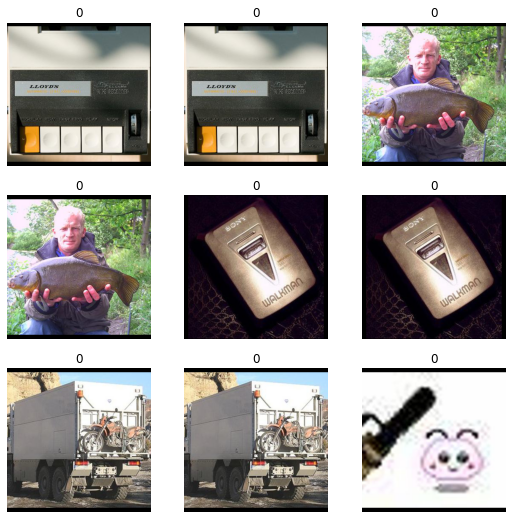

In [8]:
dls.show_batch()

In [9]:
#Not using ys, as we want to preserve the labels in outputs and foir interpretability, not training. 
class SimilarityLoss:
    def __call__(self,preds,ys):
        self.bs2=len(preds) #twice the bs
        sij=self._similarity(preds)
        pairs=self._pairs(self.bs2,preds.device)
        return F.cross_entropy(sij,pairs)
    def _similarity(self,preds):
        device=preds.device
        bs2=self.bs2
        mask=torch.ones(bs2,bs2,device=device)-torch.eye(bs2,device=device)
        sij = torch.cosine_similarity(preds[:,None].repeat(1,bs2,1),preds[None].repeat(bs2,1,1),dim=2)
        return sij*mask
    def _pairs(self,bs,device):
        return torch.flatten(torch.arange(1,self.bs2,2,device=device)[...,None].repeat(1,2)
                             -torch.tensor([0,1],dtype=torch.long,device=device))
    def activation(self,preds):
        self.bs2=len(preds)
        sij=self._similarity(preds)
        return F.softmax(preds,dim=1)
    def decodes(self,acts):
        return acts.max(dim=1)[1]

In [10]:
learn=cnn_learner(dls,resnet18,SimilarityLoss(),pretrained=False,n_out=16)

In [11]:
#learn.lr_find(end_lr=10000)

In [ ]:
learn.fit(1,lr=0.02)

epoch,train_loss,valid_loss,time


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


If you zero, you need to zero both actual value and its pair, so my zero strategy is wrong.

In [ ]:
learn.show_results(max_n=100)